In [2]:
from datetime import datetime
from astropy.time import Time
import MySQLdb as mariadb
from astropy.table import vstack, Table
from astropy.io import ascii
import numpy as np
import matplotlib.pyplot as plt

In [3]:
conn = mariadb.connect(user='auscope', passwd='password')
cursor = conn.cursor()
query = "USE auscope_db2;"
cursor.execute(query)
conn.commit()

In [4]:
query = "SELECT ExpID, Date, Date_MJD, Performance, Performance_UsedVsRecov, W_RMS_del from Hb;"
cursor.execute(query)
result = cursor.fetchall()

In [139]:
def extractStationData(station_code, database_name, mjd_start, mjd_stop, search='%'):
    conn = mariadb.connect(user='auscope', passwd='password')
    cursor = conn.cursor()
    query = "USE " + database_name +";"
    cursor.execute(query)
    query = "SELECT ExpID, Date, Date_MJD, Performance, Performance_UsedVsRecov, W_RMS_del FROM " + station_code+ " WHERE ExpID LIKE \"" + search + "\" AND Date_MJD > " + str(mjd_start) + " AND Date_MJD < " + str(mjd_stop) + " ORDER BY DATE ASC;"
    cursor.execute(query)
    result = cursor.fetchall()
    return result

In [254]:
result = extractStationData('Ke', 'auscope_db2', 0, 100000, search='%')

In [225]:
rms_table = Table(rows=result)

# filter out the -999 data rows
bad_data = []
for i in range(0, len(rms_table['col5'])):
    if rms_table['col5'][i] == -999:
        bad_data.append(i)

rms_table.remove_rows(bad_data)

In [263]:
def wRmsAnalysis(results):
    rms_table = Table(rows=results)
    # filter dummy data
    bad_data = []
    for i in range(0, len(rms_table['col5'])):
        if rms_table['col5'][i] == -999:
            bad_data.append(i)
    rms_table.remove_rows(bad_data)
    #
    N = 12
    wrms_runavg = np.convolve(np.array(rms_table['col5'], dtype=float), np.ones(N)/(N), mode='valid')
    mjd_x = np.convolve(np.array(rms_table['col2'], dtype=float), np.ones(N)/(N), mode='valid')
    print("Number of sessions: " + str(len(rms_table['col5'])))
    print("Median station W.RMS: " + str(np.median(rms_table['col5'])))
    plt.scatter(rms_table['col2'], rms_table['col5'], color='k', s=10)
    plt.plot(mjd_x, wrms_runavg, color='r')
    plt.xlabel('MJD')
    plt.show()

In [264]:
def performanceAnalysis(results):
    table = Table(rows=results)
    # filter sessions with 0% data
    bad_data = []
    for i in range(0, len(table['col3'])):
        if table['col3'][i] == 0:
            bad_data.append(i)
    table.remove_rows(bad_data)
    #
    N = 10
    wrms_runavg = np.convolve(np.array(table['col3'], dtype=float), np.ones(N)/(N), mode='valid')
    mjd_x = np.convolve(np.array(table['col2'], dtype=float), np.ones(N)/(N), mode='valid')
    print("Number of sessions: " + str(len(table['col3'])))
    print("Median station 'Performance: " + str(np.median(table['col3'])))
    plt.scatter(table['col2'], table['col3'], color='k', s=10)
    plt.plot(mjd_x, wrms_runavg, color='r')
    plt.xlabel('MJD')
    plt.show()

In [274]:
def usedVsRecoveredAnalysis(results):
    table = Table(rows=results)
    # filter sessions with 0% data
    bad_data = []
    for i in range(0, len(table['col4'])):
        if table['col4'][i] == 0 or table['col4'][i] == None:
            bad_data.append(i)
    table.remove_rows(bad_data)
    print("Number of sessions: " + str(len(table['col4'])))
    print("Median used vs recovered observations: " + str(np.median(table['col4'])))
    fig, ax = plt.subplots()
    ax.scatter(table['col2'], table['col4'], color='k', s=5)
    ax.fill_between(table['col2'], table['col4'], alpha = 0.5)
    plt.title('Fractional Used/Recovered Observations vs. Time')
    plt.xlabel('MJD')
    plt.show()

In [168]:
N = 10
wrms_runavg = np.convolve(np.array(rms_table['col5'], dtype=float), np.ones(N)/(N), mode='valid')
mjd_x = np.convolve(np.array(rms_table['col2'], dtype=float), np.ones(N)/(N), mode='valid')

Text(0.5, 0, 'MJD')

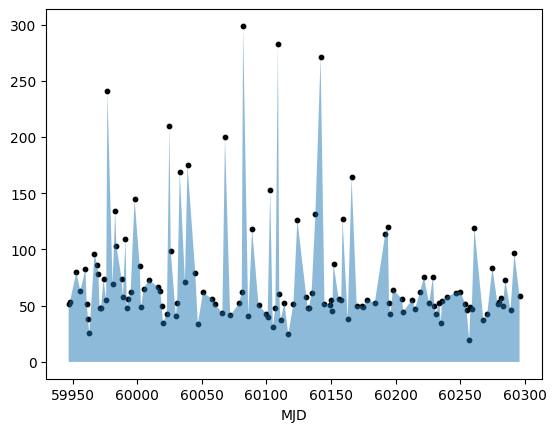

In [262]:
fig, ax = plt.subplots()
ax.scatter(rms_table['col2'], rms_table['col5'], color='k', s=10)
ax.fill_between(rms_table['col2'], rms_table['col5'], alpha = 0.5)
plt.xlabel('MJD')
#plt.plot(mjd_x, wrms_runavg, color='r')

Number of sessions: 130
Median used vs recovered observations: 0.9645


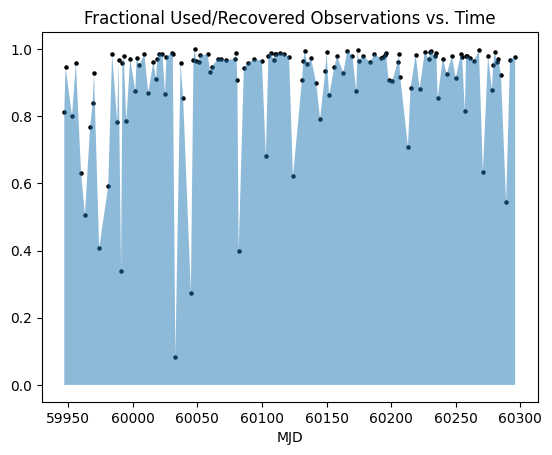

In [275]:
usedVsRecoveredAnalysis(result)

Number of sessions: 130
Median station 'Performance: 0.4595


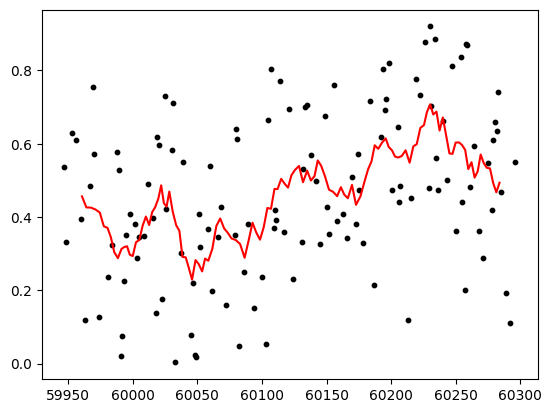

In [256]:
performanceAnalysis(result)

Number of sessions: 129
Median station W.RMS: 54.30


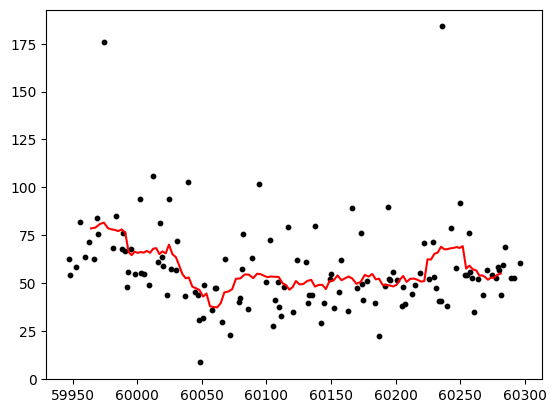

In [257]:
wRmsAnalysis(result)